## Rendering Beifong

In [1]:
import os
import numpy as np
import mitsuba
import enoki as ek

# Set the desired mitsuba variant
# mitsuba.set_variant('scalar_rgb')
# mitsuba.set_variant('scalar_mono')
mitsuba.set_variant('scalar_spectral')
# mitsuba.set_variant('gpu_spectral')
# mitsuba.set_variant('gpu_rgb')
# mitsuba.set_variant('packet_spectral')

from mitsuba.core import Bitmap, Struct, Thread
from mitsuba.core.xml import load_file

from matplotlib import pyplot as plt

# Animation bits
from mitsuba.core.xml import load_dict
from mitsuba.core import Vector3f, Transform4f
from mitsuba.core import ScalarTransform4f
import matplotlib.animation as animation
from matplotlib import cm

### Simulation Setup

In [2]:
SAM = dict({
    'type': 'independent',
    'sample_count': int(2**16),
})

INTEGRATOR = dict({
    'type': 'pathlength',
})

### Transmitter Setup
Ensure mitsuba/beifong is compiled with the correct wavelength min and max in /include/core.spectrum.h

In [3]:
# Standard MMW Radar
TX = dict({
    'type': 'fmcw',
    'fc': 94e9,
    'bandwidth': 6e9,
    'tx_power': 10e-3,
    'wrf': 2000,
    'rise_time': 200e-6,
    'hold_time': 50e-6,
    'fall_time': 200e-6,
    'wait_time': 50e-6,
})

# Grahams Ultrasound Radar
# TX = dict({
#     'type': 'fmcw',
#     'fc': 40e3,
#     'bandwidth': 2e3,
#     'tx_power': 10e-3,
#     'wrf': 10,
#     'rise_time': 90e-3,
#     'hold_time': 1e-6,
#     'fall_time': 1e-6,
#     'wait_time': 9.998e-3,
# })

### Receiver Setup

In [161]:
# rbins = 2**8
rbins = 2**10
dr = 0.03
dbins = 2**10

RX = dict({
    'type': 'hdradc',
    'pixel_format': 'luminance',
    'tr_bins': rbins,
    'fd_bins': dbins,
    'tr_min': dr,
    'tr_max': rbins*dr,
    'fd_bandwidth': 1,
    'fd_centre': 0.5,
    'rfilter': {
        'type': 'box'
    },
})

# Maybe it shouldn't ba an adc. maybe it should.
# The 'fpga' or other data processing should be seperate.
# To get a proper tf, we can imagine a filter bank. 

# Diferent kinds of signal processing approaches.
# mixed+filtered vs non.

# 

In [162]:
80e6*200e-6

16000.0

In [163]:
(150-15)/0.1

1350.0

#### Wavelength

In [164]:
C_VAC = 3e8
C_AIR = 340
# C_MED = C_AIR
C_MED = C_VAC
wlen_max = int(np.ceil(C_MED/(TX['fc'] - TX['bandwidth']/2) * 1e9))
wlen_min = int(np.ceil(C_MED/(TX['fc'] + TX['bandwidth']/2) * 1e9))

### Transmit Antenna Setup
We should also extend this and attach a signal, similar to how emitter has a film
<br> <br>
Another thought, if we were doing a phasor representation, we would still need the rms power to give to the rays. We are smarter and use wigner because it has power, time and frequency.
<br> <br>
We could extend the radiance power to include transmit antenna bandwidth considerations.

In [165]:
# Transmit Antenna/Aperture/Array
txa_size = np.array([5e-3, 5e-3, 1]) # 10mm x 10mm patch
txa_r0 = np.array([0, 0, 0.3])

# Starting orientation: z, thumb down; y, index right; x middle back
# z, boresight/up, y, right, x, forward
txa_d0_align_z = Transform4f.rotate([0,1,0], 90)
txa_d0_align_x = Transform4f.rotate([1,0,0], 90)
txa_d0 = txa_d0_align_x*txa_d0_align_z

txa_z = txa_d0.transform_vector([0,0,1])
txa_y = txa_d0.transform_vector([0,1,0])
txa_x = txa_d0.transform_vector([1,0,0])

txa_trafo = Transform4f.translate(txa_r0)*txa_d0*Transform4f.scale(txa_size)
TXA = dict({
    'type': 'rectangle',
    'to_world': txa_trafo,
    'emitter': {
        'type': 'wignertransmitter',
        'radiance': {
            'type': 'spectrum',
            'value': [(wlen_min, TX['tx_power']), (wlen_max, TX['tx_power'])],
        },
    },
})

### Receive Antenna Setup

Getting this working needs to be the next priority so that I can dump the camera centric parameters from receiver/sensor

In [166]:
# Receive Antenna/Aperture/Array
rxa_size = np.array([5e-3, 5e-3, 1]) # 10mm x 10mm patch
rxa_r0 = np.array([0, 0, 0.3])

# Starting orientation: z, thumb down; y, index right; x middle back
# z, boresight/up, y, right, x, forward
rxa_d0_align_z = Transform4f.rotate([0,1,0], 90)
rxa_d0_align_x = Transform4f.rotate([1,0,0], 90)
rxa_d0 = rxa_d0_align_x*rxa_d0_align_z

rxa_z = rxa_d0.transform_vector([0,0,1])
rxa_y = rxa_d0.transform_vector([0,1,0])
rxa_x = rxa_d0.transform_vector([1,0,0])

rxa_trafo = rxa_d0*Transform4f.translate(rxa_r0)*Transform4f.scale(rxa_size)

RXA = dict({
    'type': 'rectangle',
    'to_world': rxa_trafo,
    'receiver' : {
        'type': 'omnidirectional',
        'sampler': SAM,
        'adc': RX,
    }
})

### Scene Geometry Setup

Note: World Origin [0, 0, 0]; Object Direction [0, 0, 1], no rotation

In [167]:
# Reflector
refl_size = np.array([100e-3, 50e-3, 1])
# refl_r0 = np.array([1, 0.5, 0.3])
# refl_r0 = np.array([1, 0, 0.3])
refl_r0 = np.array([0, -2, 0.3])

# Starting orientation: z, thumb down; y, index right; x middle back
# z, boresight/up, y, right, x, forward
refl_d0_align_z = Transform4f.rotate([0,1,0], 90)
refl_d0_align_x = Transform4f.rotate([1,0,0], 90)
refl_d0 = refl_d0_align_x*refl_d0_align_z

# When the target is aligned with y axis, rotate it so that it's perpendicular to radar.
refl_d0 = Transform4f.rotate([0,0,1], 90) * refl_d0

refl_z = refl_d0.transform_vector([0,0,1])
refl_y = refl_d0.transform_vector([0,1,0])
refl_x = refl_d0.transform_vector([1,0,0])

refl_trafo = Transform4f.translate(refl_r0)*refl_d0*Transform4f.scale(refl_size)


# Ground
gnd_size = np.array([20, 20, 1])
gnd_r0 = np.array([0, 0, 0])
gnd_d0 = Transform4f.rotate([0,0,1], 0)

gnd_trafo = Transform4f.translate(gnd_r0)*gnd_d0*Transform4f.scale(gnd_size)


# Car
car_size = np.array([1e-3, 1e-3, 1e-3])
car_r0 = np.array([10, 3, 1])

car_d0_align_z = Transform4f.rotate([1,0,0], 90)
car_d0_align_x = Transform4f.rotate([0,0,1], -20)
car_d0 = car_d0_align_x*car_d0_align_z

car_z = car_d0.transform_vector([0,0,1])
car_y = car_d0.transform_vector([0,1,0])
car_x = car_d0.transform_vector([1,0,0])

car_trafo = Transform4f.translate(car_r0)*car_d0*Transform4f.scale(car_size)

### Object BSDFs

In [168]:
B_GND = dict({
    'type': 'twosided',
    'id': 'material',
    'bsdf': {
        'type': 'diffuse',
#         'type': 'plastic',
#         'specular_reflectance': {
        'reflectance': {
            'type': 'spectrum',
            'value': [(wlen_min, 0.5), (wlen_max, 0.5)],
        },
    },
})

B_REFL = dict({
    'type': 'twosided',
    'id': 'material',
    'bsdf': {
        'type': 'diffuse',
#         'type': 'conductor',
#         'type': 'roughconductor',
        'reflectance': {
#         'specular_reflectance': {
            'type': 'spectrum',
            'value': [(wlen_min, 1), (wlen_max, 1)],
        },
    },
})

B_CAR = dict({
    'type': 'twosided',
    'id': 'material',
    'bsdf': {
        # 'type': 'diffuse',
        # 'reflectance': {
        'type': 'roughconductor',
        # 'type': 'plastic',
        'specular_reflectance': {
            'type': 'spectrum',
            'value': [(wlen_min, 1), (wlen_max, 1)],
        },
    },
})

### Objects

In [169]:
REFL = dict({
    'type': 'rectangle',
    'to_world': refl_trafo,
    'bsdf': B_REFL,
})

GND = dict({
    'type': 'rectangle',
    'to_world': gnd_trafo,
    'bsdf': B_GND,
})

CAR = dict({
    'type': 'obj',
    'filename': './Bus.obj',
    # 'filename': './Car-body.ply',
    # 'filename': './Motorbike_ply.ply',
    'to_world': car_trafo,
    'bsdf': B_CAR,
})

### Load All Parameters into Scene

In [170]:
scene = load_dict({
    'type': 'scene',
    'integrator': INTEGRATOR,
    'receiver': RXA,
    'emitter': TXA,
    's0': REFL,
    's1': GND,
#     's2': CAR,
})

## Render the Scene
After rendering, the rendered data is stored in the film

In [171]:
scene.integrator().receive(scene, scene.receivers()[0])
adc = scene.receivers()[0].adc()
bmp = adc.bitmap(raw=True)
bmp_np = np.array(bmp)

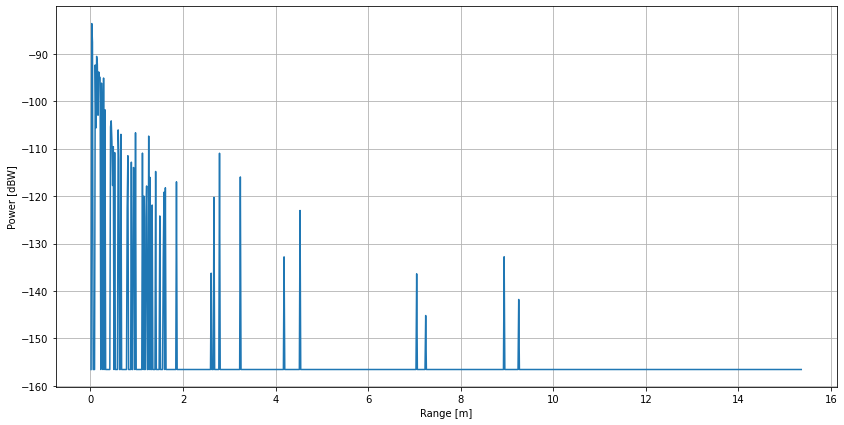

In [177]:
mask = bmp_np[:,:,0]>0
vals = (bmp_np[:,:,0]*mask/SAM["sample_count"])[0] + np.finfo(float).eps
xvals = (np.linspace(RX['tr_min'], RX['tr_max'], RX['tr_bins']))/2

fig1 = plt.figure(figsize=(14, 7))
axes1 = fig1.add_subplot()
# axes1.imshow(bmp_np[:,:,0]*mask, interpolation='nearest')
axes1.plot(xvals, 10*np.log10(vals))
axes1.set_xlabel("Range [m]")
axes1.set_ylabel("Power [dBW]")
axes1.grid()

Text(0, 0.5, 'Power [dBW]')

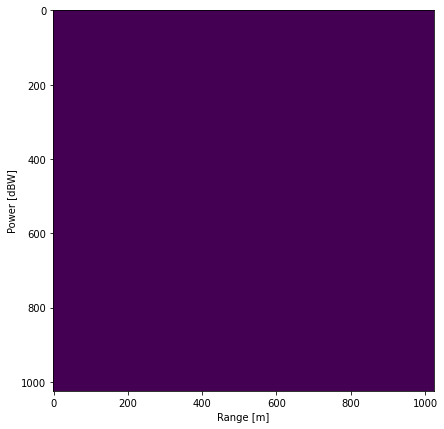

In [182]:
mask = bmp_np[:,:,0]>0
vals = (bmp_np[:,:,0]*mask/SAM["sample_count"]) + np.finfo(float).eps
xvals = (np.linspace(RX['tr_min'], RX['tr_max'], RX['tr_bins']))/2

fig1 = plt.figure(figsize=(14, 7))
axes1 = fig1.add_subplot()
axes1.imshow(10*np.log10(vals), interpolation='nearest')
# axes1.plot(xvals, 10*np.log10(vals))
axes1.set_xlabel("Range [m]")
axes1.set_ylabel("Power [dBW]")
# axes1.grid()

#### Idea
As part of a pipeline, perhaps we could set the rendering destination file to be a fifo pipe which can then be streamed.

## Rotate about the origin and render the signal

In [150]:
# Initial Angle
theta_0 = np.deg2rad(0)
# Initial Time
t_0 = 0
# Angular velocity rad/s
omega = 3*2*np.pi

# Time-based waveforms or angular position-based waveforms?
mode = "position"

if mode=="position":
    n_revs = 1
    da = 1/2**8
    dt = n_revs*da/(omega/(2*np.pi))
    n_bins_slow = int(np.ceil(n_revs/da))

elif mode=="time":
    n_secs = 1
    dt = 0.01
    n_bins_slow = int(np.ceil(n_secs/dt))

# Storage
record = np.zeros([n_bins_slow, 2+RX['tr_bins']])

txa_new = txa_trafo
rxa_new = rxa_trafo

t = t_0
theta = theta_0

for i in range(n_bins_slow):
    
    # Gotta find smarter way to update scene
    TXA = dict({
        'type': 'rectangle',
        'to_world': txa_new,
        'emitter': {
            'type': 'wignertransmitter',
            'radiance': {
                'type': 'spectrum',
                'value': [(wlen_min, TX['tx_power']), (wlen_max, TX['tx_power'])],
            },
        },
    })

    RXA = dict({
        'type': 'rectangle',
        'to_world': rxa_new,
        'receiver' : {
            'type': 'omnidirectional',
            'sampler': SAM,
            'adc': RX,
        }
    })
    
    scene = load_dict({
        'type': 'scene',
        'integrator': INTEGRATOR,
        'sensor': RXA,
        'emitter': TXA,
        's0': REFL,
        's1': GND,
    #     's2': CAR,
    })
    
    # Render the scene
    scene.integrator().receive(scene, scene.receivers()[0])
    adc = scene.receivers()[0].adc()
    # Extract the values from the adc and store them on disk
    bmp_np = np.array(adc.bitmap(raw=True))    
    record[i, :] = np.hstack((t, theta, bmp_np[:,:,0][0]))
    
    # Update the transform
    # Positive rotation gives a negative angle
    txa_d = Transform4f.rotate(txa_y, np.rad2deg(-omega)*dt)
    
    txa_x = txa_d.transform_vector(txa_x)
    txa_y = txa_d.transform_vector(txa_y)
    txa_z = txa_d.transform_vector(txa_z)
    txa_new = txa_d*txa_new
    
    rxa_x = txa_d.transform_vector(rxa_x)
    rxa_y = txa_d.transform_vector(rxa_y)
    rxa_z = txa_d.transform_vector(rxa_z)
    rxa_new = txa_d*rxa_new

    theta+=omega*dt
    t+=dt


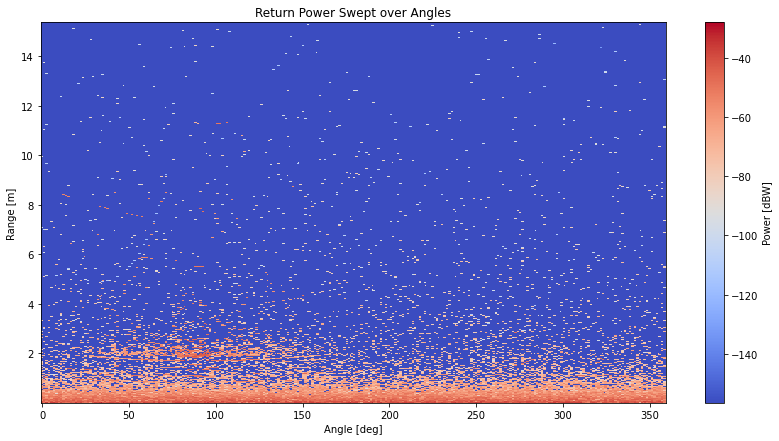

In [151]:
# Outputs
# record_log = 10*np.log10(np.abs(record[record>0]) + np.finfo(float).eps)
record_log = 10*np.log10(np.abs(record[:,2:]) + np.finfo(float).eps)
rs = (np.linspace(RX['tr_min'], RX['tr_max'], RX['tr_bins']))/2

# thetas = np.arange(theta_0, theta_0 + (n_frames)*omega*dt, omega*dt)
thetas = record[:,1]
rr, tt = np.meshgrid(rs, thetas)

minc = record_log[(record_log > -160)].min()
maxc = record_log.max()

fig1 = plt.figure(figsize=(14, 7))
axes1 = fig1.add_subplot()
ret = axes1.pcolormesh(np.rad2deg(tt), rr, record_log, cmap=cm.coolwarm, vmin=minc, vmax=maxc, shading='auto')
# axes1 = fig1.add_subplot(projection='polar')
# ret = axes1.pcolormesh(tt, rr, record_log, cmap=cm.coolwarm, vmin=minc, vmax=maxc, shading='auto')
axes1.set_xlabel('Angle [deg]')
axes1.set_ylabel('Range [m]')
axes1.set_title('Return Power Swept over Angles')

cbar = fig1.colorbar(ret)
cbar.set_label('Power [dBW]')